# Event Plots (inline version)

A NB template to ilustrate how to examine the features of events

In [1]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-07-11 15:26:26


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import time
import tables as tb
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from invisible_cities.database import load_db

In [5]:
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units

In [6]:
from invisible_cities.icaro.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus

In [7]:
from invisible_cities.icaro.pmaps_mpl import plot_s12

In [8]:
from invisible_cities.sierpe                 import blr

In [9]:
from invisible_cities.reco                   import peak_functions_c as cpf

In [10]:
from invisible_cities.core.ic_types_c          import minmax

### Run Parameters

In [11]:
run_number = 4455

In [12]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
coeff_c    = abs(DataPMT.coeff_c.values)
coeff_blr  = abs(DataPMT.coeff_blr.values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)

In [13]:
RWF_file = os.path.join(os.environ['IC_DATA'],
                        'LSC/wvfms/{}/dst_waves.gdcsnext.000_{}.root.h5'.format(run_number, run_number))
print('RWF file = {}'.format(RWF_file))

RWF file = /Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/4455/dst_waves.gdcsnext.000_4455.root.h5


In [14]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,18,PMT1,1,-23.9414,65.7785,0.000788,0.000002,25.67,0.75,11.24
1,1,22,PMT3,1,-44.9951,-53.6231,0.000789,0.000002,26.47,0.78,12.21
2,2,19,PMT2,1,68.9365,-12.1554,0.000775,0.000002,28.61,0.75,10.52
3,3,23,PMT4,1,0.0000,185.0000,0.000778,0.000002,26.15,0.73,10.01
4,4,9,PMTC,1,-118.9160,141.7180,0.000789,0.000002,27.13,0.80,9.70
5,5,8,PMTB,1,-182.1890,32.1249,0.000781,0.000002,21.80,0.78,8.18
6,6,5,PMTA,1,-160.2150,-92.5000,0.000794,0.000002,24.59,0.76,8.98
7,7,4,PMT9,1,-63.2737,-173.8430,0.000773,0.000002,34.97,0.77,13.29
8,8,1,PMT8,1,63.2737,-173.8430,0.000788,0.000002,22.23,0.81,8.32
9,10,31,PMT6,1,182.1890,32.1249,0.000782,0.000002,20.85,0.79,8.07


In [15]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [16]:
h5rwf = tb.open_file(RWF_file,'r')

In [17]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [18]:
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 170
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


In [19]:
s1par = S12Params(time = minmax(min   =  0 * units.mus,
                                max   = 600 * units.mus),
                      length = minmax(min =   6,
                                      max =  20),
                      stride              =   4,
                      rebin               = False)

In [20]:
s2par = S12Params(time = minmax(min   =    460 * units.mus,
                                    max   =   1300 * units.mus),
                      length = minmax(min =     80,
                                      max = 200000),
                      stride              =     40,
                      rebin               = True)

In [21]:
thr = ThresholdParams(thr_s1   =  3 * units.pes,
                      thr_s2   =  2   * units.pes,
                      thr_MAU  =  3   * units.adc,
                      thr_sipm =  3.5   * units.pes,
                      thr_SIPM = 20   * units.pes )

#### events

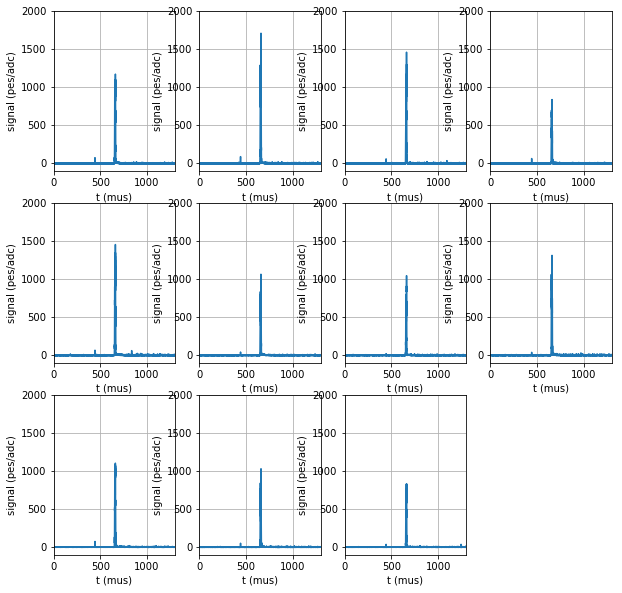

In [22]:
event=0

CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  2000)

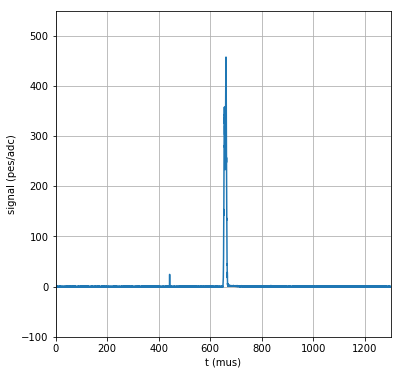

In [23]:
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=550)

In [24]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

In [25]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      0.2 mus , energy =    124.6 pes
        height =     24.4 pes tmin-tmax = minmax(min=442.325, max=442.5) mus  

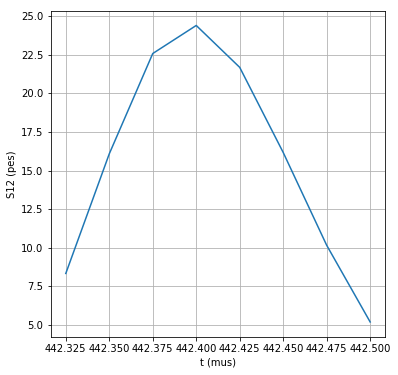

In [26]:
plot_s12(s1, figsize=(6,6))

In [27]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 25 width =     23.3 mus , energy = 153479.9 pes
        height =  16865.7 pes tmin-tmax = minmax(min=649.7625, max=673.0375) mus  

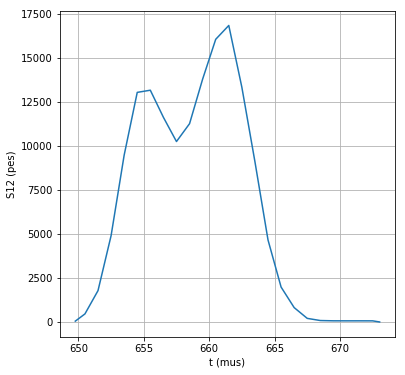

In [28]:
plot_s12(s2, figsize=(6,6))

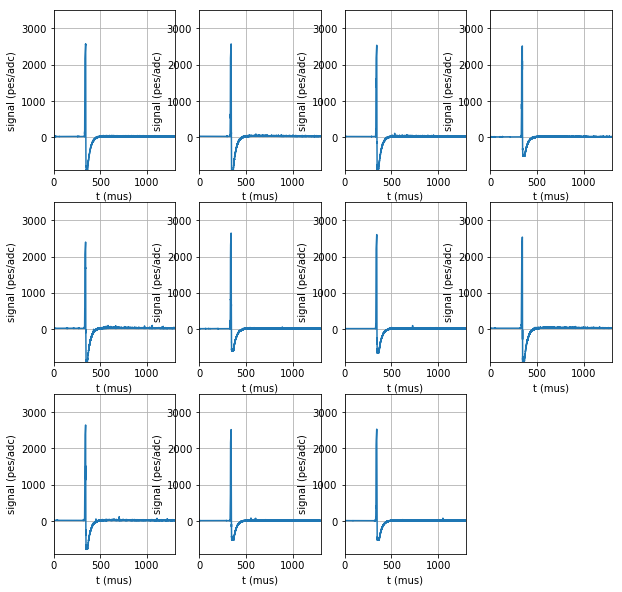

In [29]:
event=1

CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -900,
                             signal_max =  3500)

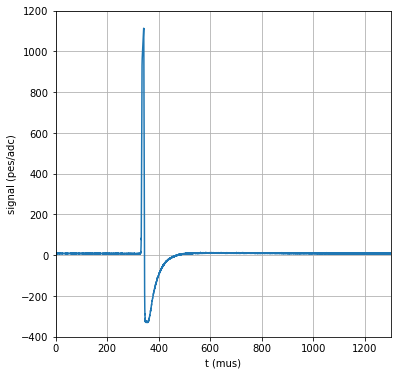

In [30]:
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-400, 
                            signal_max=1200)

In [31]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

In [32]:
s1

S1 (number of peaks = 4)
peak number = 0: Peak(samples = 6 width =      0.1 mus , energy =     23.3 pes
        height =      4.6 pes tmin-tmax = minmax(min=476.45, max=476.575) mus  
peak number = 1: Peak(samples = 14 width =      0.3 mus , energy =     50.8 pes
        height =      4.9 pes tmin-tmax = minmax(min=476.975, max=477.3) mus  
peak number = 2: Peak(samples = 7 width =      0.1 mus , energy =     26.9 pes
        height =      4.4 pes tmin-tmax = minmax(min=480.125, max=480.27500000000003) mus  
peak number = 3: Peak(samples = 8 width =      0.2 mus , energy =     27.2 pes
        height =      3.7 pes tmin-tmax = minmax(min=481.225, max=481.40000000000003) mus  

In [33]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 825 width =    824.0 mus , energy = 309964.9 pes
        height =    458.2 pes tmin-tmax = minmax(min=475.5125, max=1299.5) mus  

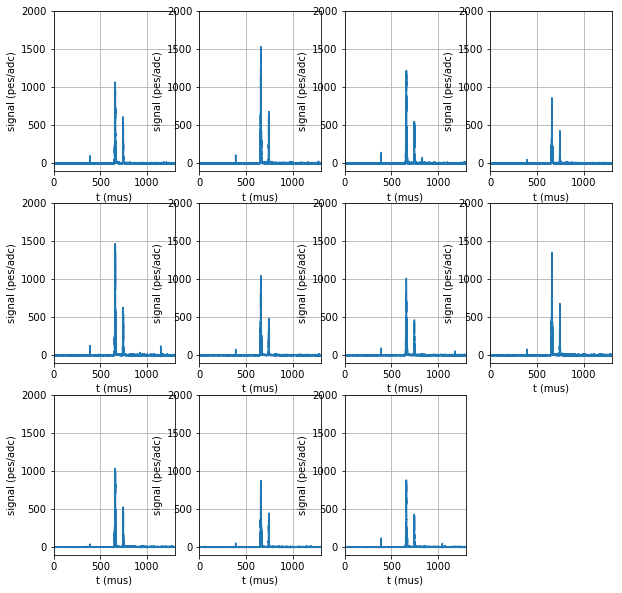

In [34]:
event=2

CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  2000)

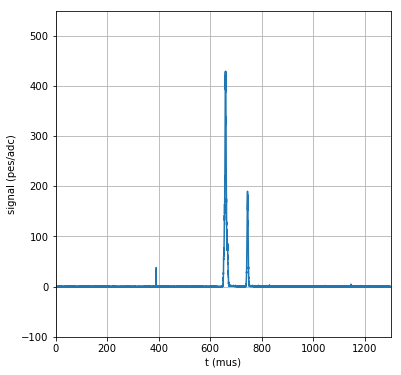

In [35]:
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=550)

In [36]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

In [37]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      0.2 mus , energy =    204.6 pes
        height =     37.9 pes tmin-tmax = minmax(min=390.2, max=390.45) mus  

In [38]:
s2

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 28 width =     26.4 mus , energy = 128987.5 pes
        height =  16511.8 pes tmin-tmax = minmax(min=648.975, max=675.35) mus  
peak number = 1: Peak(samples = 16 width =     14.6 mus , energy =  38343.7 pes
        height =   7106.2 pes tmin-tmax = minmax(min=738.6625, max=753.3000000000001) mus  

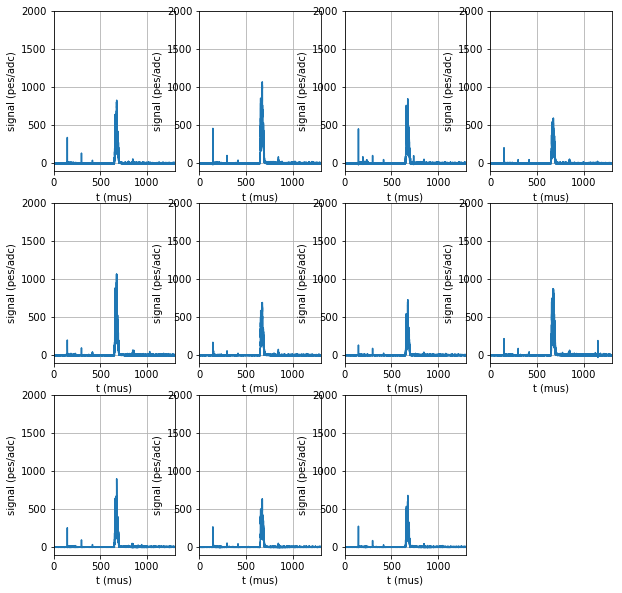

In [39]:
event=3

CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  2000)

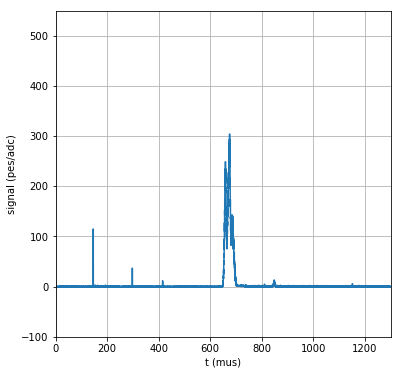

In [40]:
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=550)

In [41]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

In [42]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 14 width =      0.3 mus , energy =    236.8 pes
        height =     36.8 pes tmin-tmax = minmax(min=297.475, max=297.8) mus  

In [43]:
s2

S2 (number of peaks = 3)
peak number = 0: Peak(samples = 62 width =     60.4 mus , energy = 249949.3 pes
        height =  10968.8 pes tmin-tmax = minmax(min=648.6750000000001, max=709.0375) mus  
peak number = 1: Peak(samples = 3 width =      1.5 mus , energy =    124.9 pes
        height =     58.6 pes tmin-tmax = minmax(min=727.65, max=729.1625) mus  
peak number = 2: Peak(samples = 12 width =     10.6 mus , energy =   2187.0 pes
        height =    370.4 pes tmin-tmax = minmax(min=842.7625, max=853.4) mus  

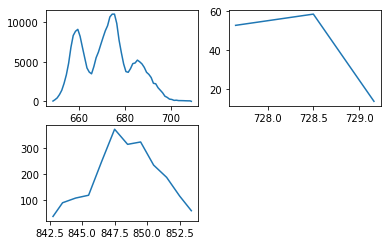

In [44]:
plot_s12(s2, figsize=(6,6))

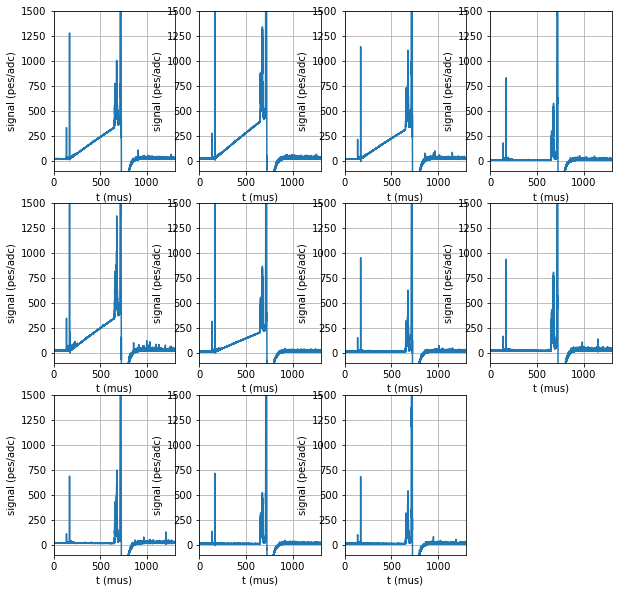

In [45]:
event=4
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)

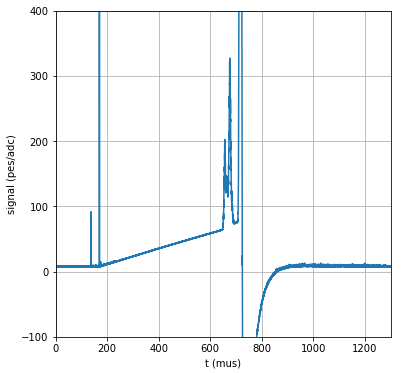

In [46]:
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)

In [47]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

In [48]:
s1

S1 (number of peaks = 0)

In [49]:
s2

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 725 width =    723.9 mus , energy = 1555411.0 pes
        height =  49025.3 pes tmin-tmax = minmax(min=0.5, max=724.3625000000001) mus  
peak number = 1: Peak(samples = 439 width =    437.9 mus , energy = 142562.3 pes
        height =    396.1 pes tmin-tmax = minmax(min=861.6125000000001, max=1299.5) mus  

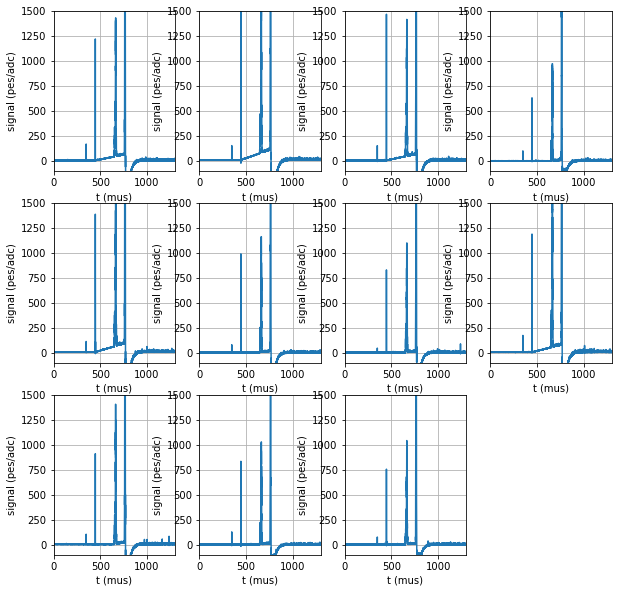

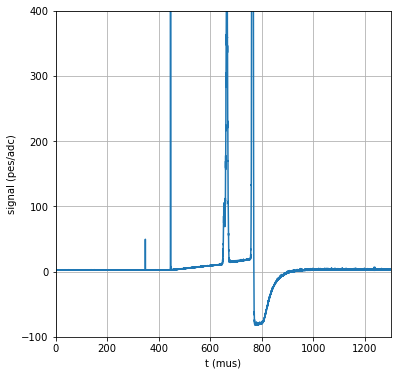

In [50]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

In [51]:
s1

S1 (number of peaks = 12)
peak number = 0: Peak(samples = 15 width =      0.3 mus , energy =    302.3 pes
        height =     49.5 pes tmin-tmax = minmax(min=347.975, max=348.325) mus  
peak number = 1: Peak(samples = 10 width =      0.2 mus , energy =     45.3 pes
        height =      6.2 pes tmin-tmax = minmax(min=446.77500000000003, max=447.0) mus  
peak number = 2: Peak(samples = 7 width =      0.1 mus , energy =     38.7 pes
        height =      7.7 pes tmin-tmax = minmax(min=447.90000000000003, max=448.05) mus  
peak number = 3: Peak(samples = 8 width =      0.2 mus , energy =     25.1 pes
        height =      3.3 pes tmin-tmax = minmax(min=460.95, max=461.125) mus  
peak number = 4: Peak(samples = 6 width =      0.1 mus , energy =     19.0 pes
        height =      3.4 pes tmin-tmax = minmax(min=461.95, max=462.075) mus  
peak number = 5: Peak(samples = 6 width =      0.1 mus , energy =     18.9 pes
        height =      3.3 pes tmin-tmax = minmax(min=462.27500000000003, max

In [52]:
s2

S2 (number of peaks = 3)
peak number = 0: Peak(samples = 770 width =    768.7 mus , energy = 618368.7 pes
        height =  42036.4 pes tmin-tmax = minmax(min=0.5, max=769.2375000000001) mus  
peak number = 1: Peak(samples = 4 width =      2.5 mus , energy =    219.7 pes
        height =     77.9 pes tmin-tmax = minmax(min=943.6875, max=946.1375) mus  
peak number = 2: Peak(samples = 353 width =    351.9 mus , energy =  38903.0 pes
        height =    143.2 pes tmin-tmax = minmax(min=947.6375, max=1299.5) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 702 width =    701.0 mus , energy = 3083006.3 pes
        height =  53374.2 pes tmin-tmax = minmax(min=0.5, max=701.45) mus  
peak number = 1: Peak(samples = 468 width =    467.0 mus , energy = 235763.2 pes
        height =   1261.0 pes tmin-tmax = minmax(min=832.5, max=1299.5) mus  

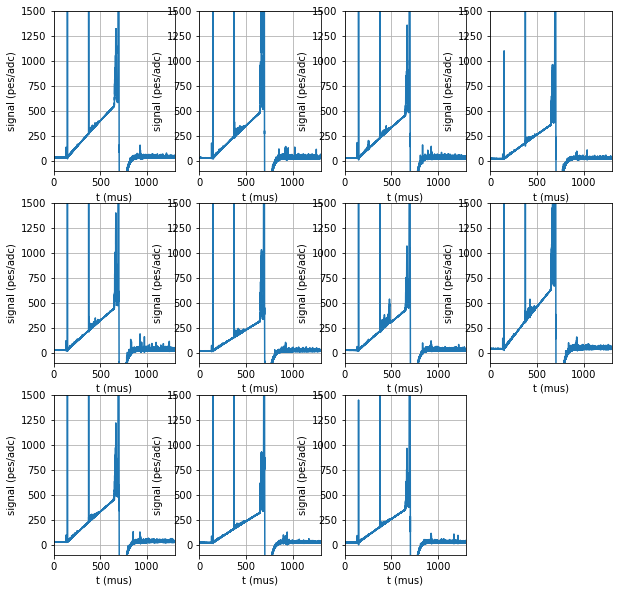

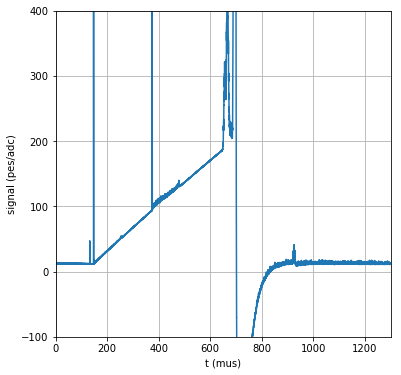

In [53]:
event=6
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
s1
s2

S1 (number of peaks = 28)
peak number = 0: Peak(samples = 12 width =      0.3 mus , energy =     45.0 pes
        height =      5.5 pes tmin-tmax = minmax(min=87.95, max=88.22500000000001) mus  
peak number = 1: Peak(samples = 7 width =      0.1 mus , energy =     28.1 pes
        height =      5.1 pes tmin-tmax = minmax(min=89.15, max=89.3) mus  
peak number = 2: Peak(samples = 13 width =      0.3 mus , energy =     48.6 pes
        height =      5.1 pes tmin-tmax = minmax(min=89.47500000000001, max=89.775) mus  
peak number = 3: Peak(samples = 17 width =      0.4 mus , energy =     59.0 pes
        height =      4.2 pes tmin-tmax = minmax(min=120.025, max=120.425) mus  
peak number = 4: Peak(samples = 6 width =      0.1 mus , energy =     19.4 pes
        height =      3.7 pes tmin-tmax = minmax(min=134.125, max=134.25) mus  
peak number = 5: Peak(samples = 12 width =      0.3 mus , energy =     51.1 pes
        height =      4.9 pes tmin-tmax = minmax(min=134.425, max=134.7) mus  
p

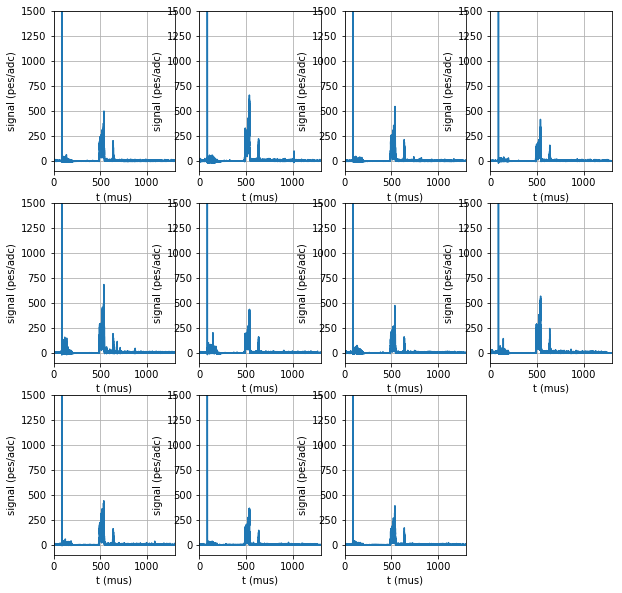

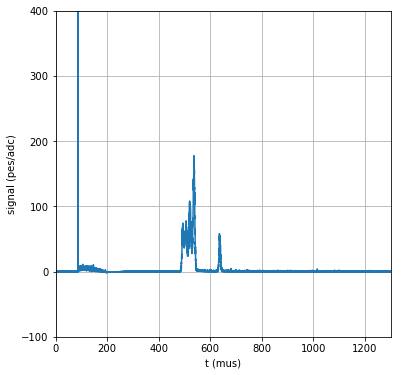

In [54]:
event=7
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 15 width =      0.3 mus , energy =    422.6 pes
        height =     69.5 pes tmin-tmax = minmax(min=154.05, max=154.4) mus  

S2 (number of peaks = 10)
peak number = 0: Peak(samples = 65 width =     63.5 mus , energy = 269172.3 pes
        height =  14126.3 pes tmin-tmax = minmax(min=648.7625, max=712.25) mus  
peak number = 1: Peak(samples = 7 width =      5.4 mus , energy =    357.7 pes
        height =     62.2 pes tmin-tmax = minmax(min=714.775, max=720.1875) mus  
peak number = 2: Peak(samples = 3 width =      1.6 mus , energy =   8251.0 pes
        height =   7923.7 pes tmin-tmax = minmax(min=922.8000000000001, max=924.35) mus  
peak number = 3: Peak(samples = 14 width =     12.3 mus , energy =    888.5 pes
        height =    119.7 pes tmin-tmax = minmax(min=929.775, max=942.1) mus  
peak number = 4: Peak(samples = 30 width =     28.6 mus , energy =   2071.0 pes
        height =    134.9 pes tmin-tmax = minmax(min=943.800

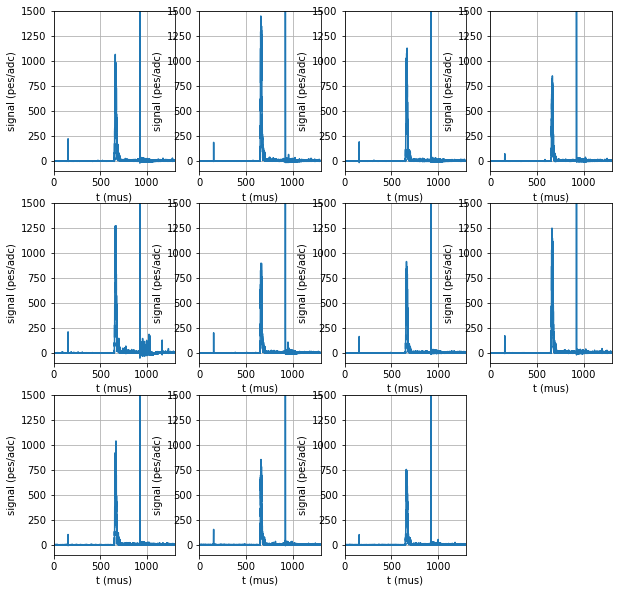

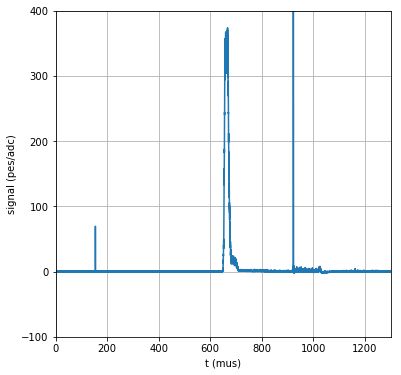

In [55]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 290)
peak number = 0: Peak(samples = 7 width =      0.1 mus , energy =     21.7 pes
        height =      3.5 pes tmin-tmax = minmax(min=117.25, max=117.4) mus  
peak number = 1: Peak(samples = 6 width =      0.1 mus , energy =     22.6 pes
        height =      4.1 pes tmin-tmax = minmax(min=123.95, max=124.075) mus  
peak number = 2: Peak(samples = 6 width =      0.1 mus , energy =     23.0 pes
        height =      4.2 pes tmin-tmax = minmax(min=132.7, max=132.825) mus  
peak number = 3: Peak(samples = 8 width =      0.2 mus , energy =     30.6 pes
        height =      4.2 pes tmin-tmax = minmax(min=135.675, max=135.85) mus  
peak number = 4: Peak(samples = 6 width =      0.1 mus , energy =     21.6 pes
        height =      3.7 pes tmin-tmax = minmax(min=136.425, max=136.55) mus  
peak number = 5: Peak(samples = 8 width =      0.2 mus , energy =     32.1 pes
        height =      4.3 pes tmin-tmax = minmax(min=139.70000000000002, max=139.875) mus  
peak numbe

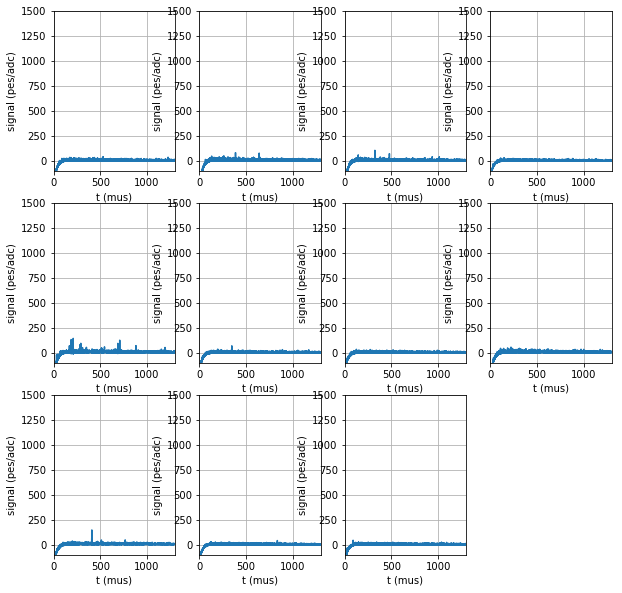

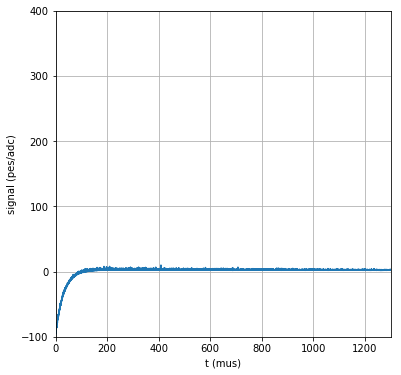

In [56]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 12 width =      0.3 mus , energy =    371.4 pes
        height =     62.7 pes tmin-tmax = minmax(min=171.025, max=171.3) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 69 width =     67.5 mus , energy = 230782.8 pes
        height =  12573.2 pes tmin-tmax = minmax(min=635.75, max=703.275) mus  
peak number = 1: Peak(samples = 3 width =      1.5 mus , energy =    109.1 pes
        height =     56.1 pes tmin-tmax = minmax(min=716.5500000000001, max=718.0875) mus  



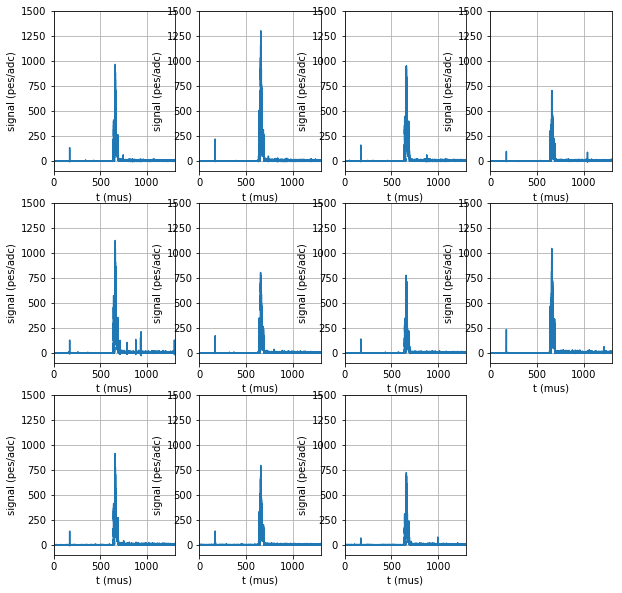

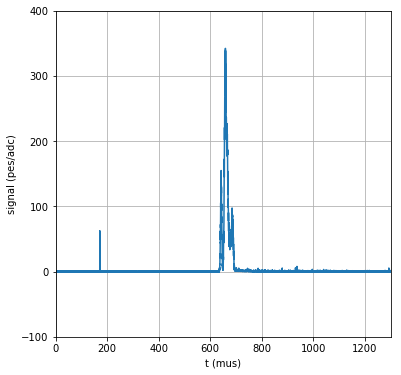

In [57]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 0)

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 825 width =    824.0 mus , energy = 1322248.7 pes
        height =  46367.4 pes tmin-tmax = minmax(min=0.5, max=824.4875000000001) mus  
peak number = 1: Peak(samples = 346 width =    344.8 mus , energy = 145659.8 pes
        height =    499.7 pes tmin-tmax = minmax(min=954.6875, max=1299.5) mus  



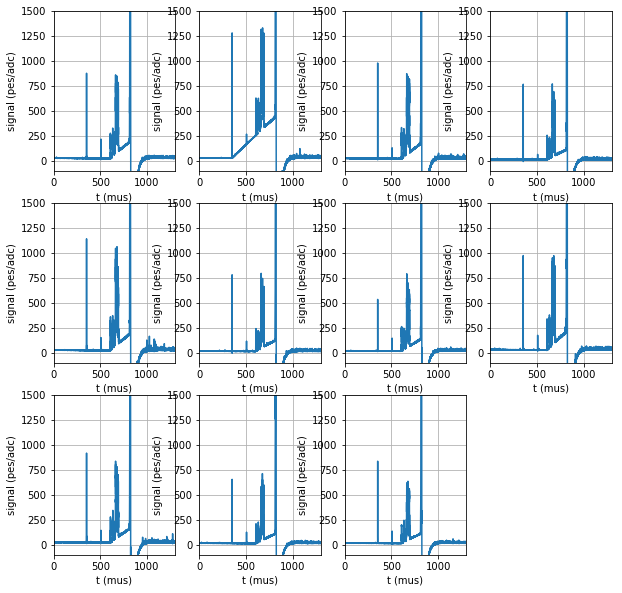

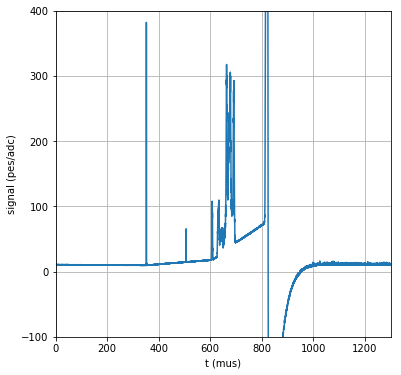

In [58]:
event=11
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 2)
peak number = 0: Peak(samples = 6 width =      0.1 mus , energy =   -417.3 pes
        height =    -61.6 pes tmin-tmax = minmax(min=284.7, max=284.825) mus  
peak number = 1: Peak(samples = 13 width =      0.3 mus , energy =     65.9 pes
        height =      6.8 pes tmin-tmax = minmax(min=422.90000000000003, max=423.2) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 1300 width =   1299.0 mus , energy = 226204.5 pes
        height =  43980.8 pes tmin-tmax = minmax(min=0.5, max=1299.5) mus  



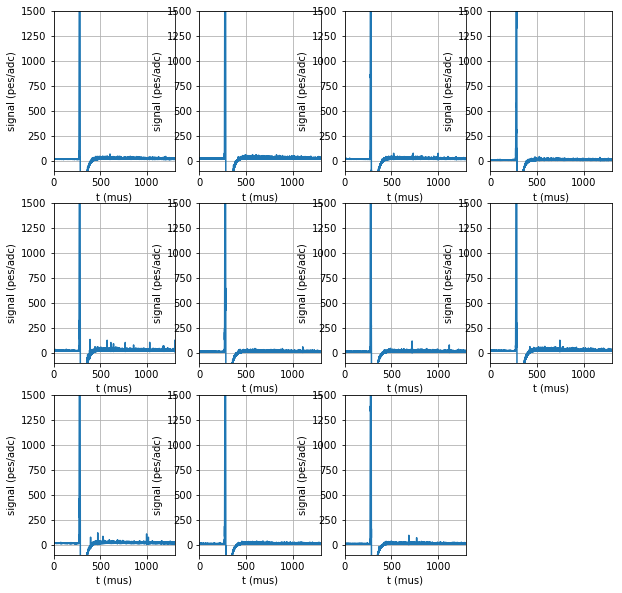

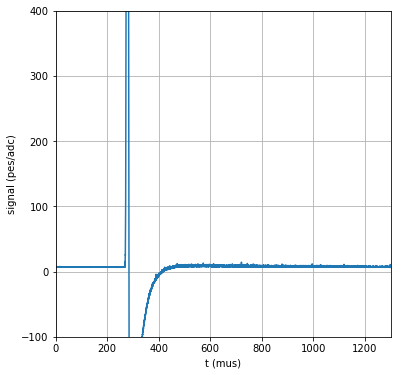

In [59]:
event=12
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 2)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =    323.4 pes
        height =     56.8 pes tmin-tmax = minmax(min=130.2, max=130.5) mus  
peak number = 1: Peak(samples = 14 width =      0.3 mus , energy =    395.8 pes
        height =     64.8 pes tmin-tmax = minmax(min=292.55, max=292.875) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 41 width =     39.2 mus , energy = 144426.5 pes
        height =  10331.6 pes tmin-tmax = minmax(min=648.875, max=688.0500000000001) mus  
peak number = 1: Peak(samples = 12 width =     10.8 mus , energy =   3369.6 pes
        height =    489.5 pes tmin-tmax = minmax(min=837.5875, max=848.4375) mus  



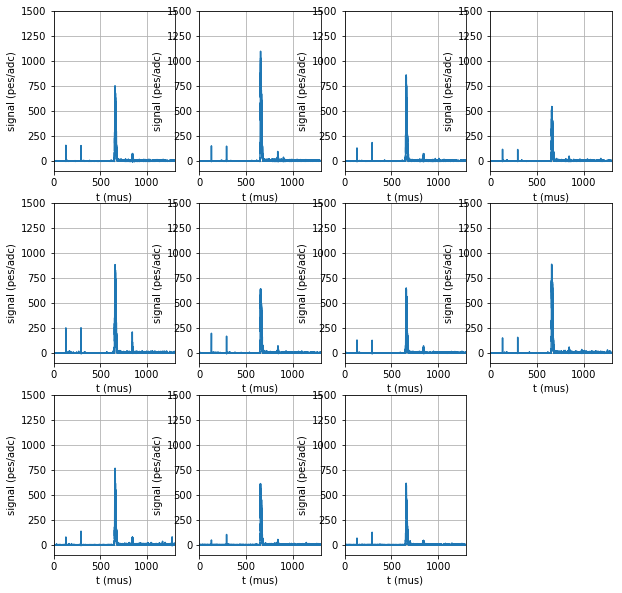

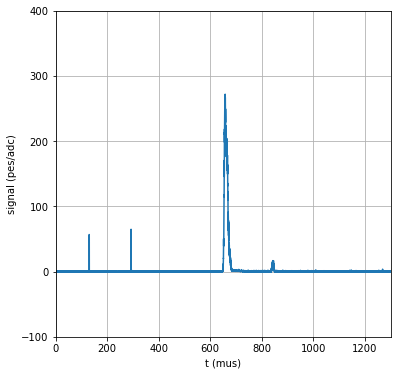

In [60]:
event=13
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 15 width =      0.3 mus , energy =    307.8 pes
        height =     55.1 pes tmin-tmax = minmax(min=127.45, max=127.8) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 43 width =     41.3 mus , energy = 133490.1 pes
        height =  10601.5 pes tmin-tmax = minmax(min=648.8000000000001, max=690.1375) mus  



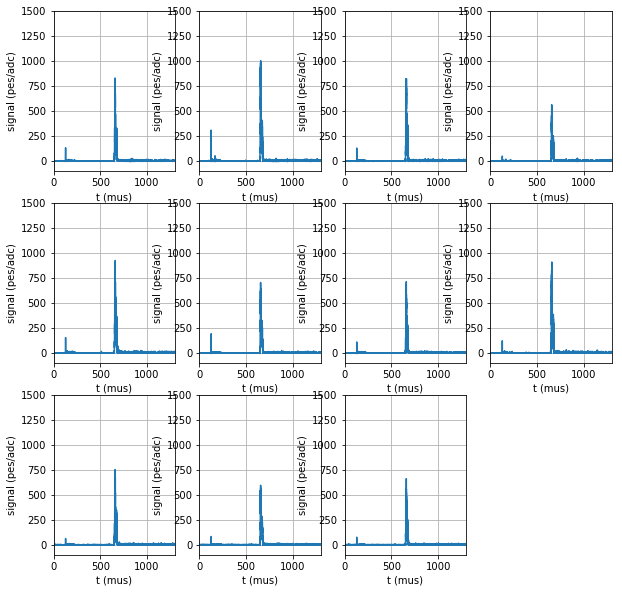

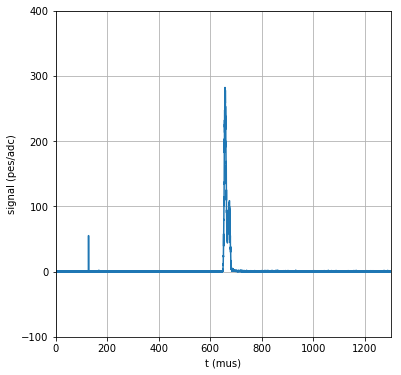

In [61]:
event=14
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 34)
peak number = 0: Peak(samples = 14 width =      0.3 mus , energy =    390.4 pes
        height =     71.3 pes tmin-tmax = minmax(min=139.975, max=140.3) mus  
peak number = 1: Peak(samples = 6 width =      0.1 mus , energy =     20.1 pes
        height =      3.6 pes tmin-tmax = minmax(min=282.90000000000003, max=283.02500000000003) mus  
peak number = 2: Peak(samples = 6 width =      0.1 mus , energy =     22.2 pes
        height =      4.1 pes tmin-tmax = minmax(min=284.15000000000003, max=284.27500000000003) mus  
peak number = 3: Peak(samples = 8 width =      0.2 mus , energy =     33.3 pes
        height =      4.8 pes tmin-tmax = minmax(min=284.925, max=285.1) mus  
peak number = 4: Peak(samples = 14 width =      0.3 mus , energy =     51.8 pes
        height =      4.2 pes tmin-tmax = minmax(min=324.875, max=325.2) mus  
peak number = 5: Peak(samples = 18 width =      0.4 mus , energy =     67.9 pes
        height =      5.4 pes tmin-tmax = minmax(min=3

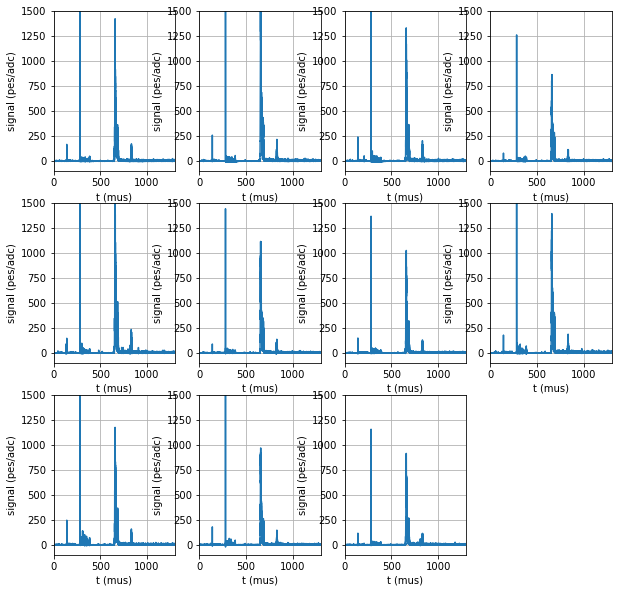

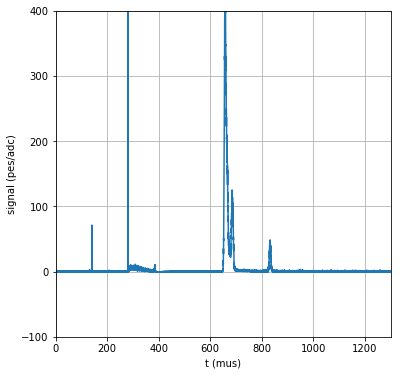

In [62]:
event=15
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 0)

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 1039 width =   1037.8 mus , energy = 3025693.6 pes
        height =  51052.5 pes tmin-tmax = minmax(min=0.5, max=1038.35) mus  
peak number = 1: Peak(samples = 132 width =    131.0 mus , energy =  53942.4 pes
        height =    557.1 pes tmin-tmax = minmax(min=1168.5375000000001, max=1299.5) mus  



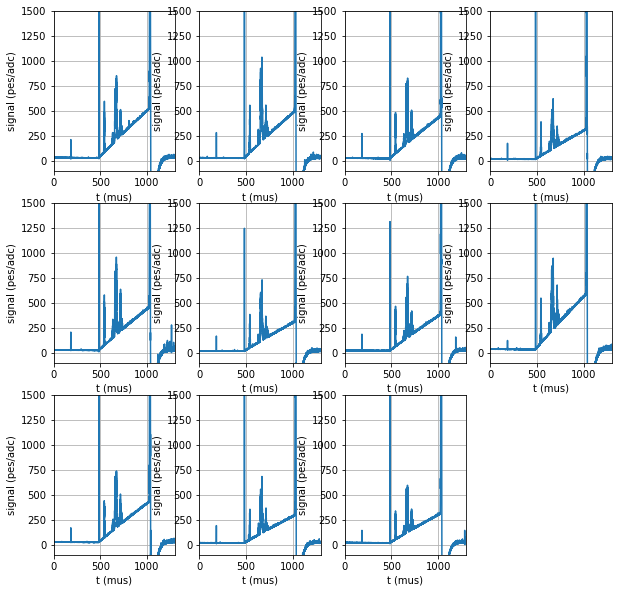

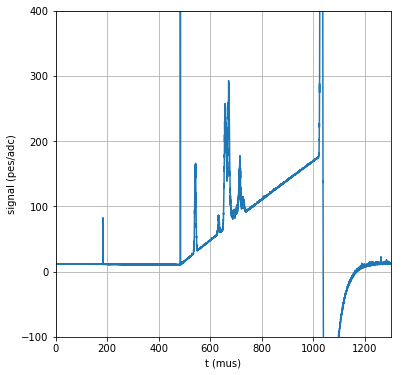

In [63]:
event=16
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      0.2 mus , energy =    263.6 pes
        height =     46.3 pes tmin-tmax = minmax(min=132.25, max=132.5) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 40 width =     38.8 mus , energy = 132854.2 pes
        height =  11847.8 pes tmin-tmax = minmax(min=648.5375, max=687.2875) mus  



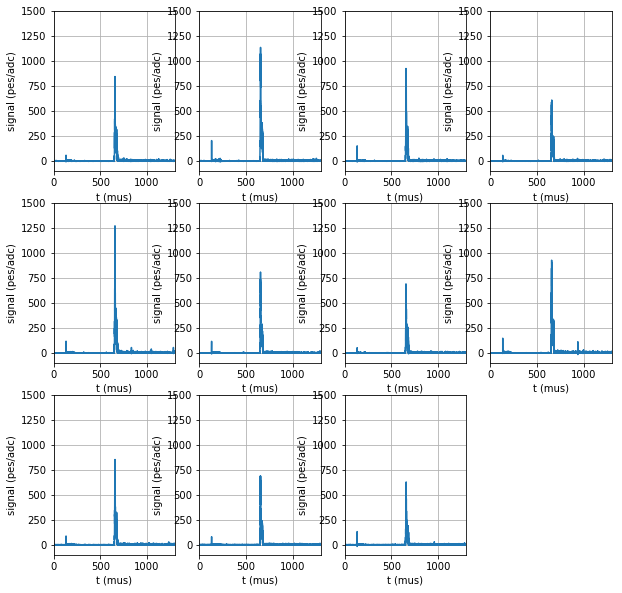

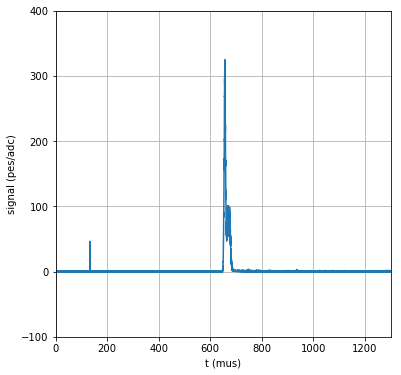

In [64]:
event=17
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 6)
peak number = 0: Peak(samples = 9 width =      0.2 mus , energy =     29.9 pes
        height =      3.8 pes tmin-tmax = minmax(min=445.65000000000003, max=445.85) mus  
peak number = 1: Peak(samples = 16 width =      0.4 mus , energy =     57.8 pes
        height =      4.3 pes tmin-tmax = minmax(min=447.02500000000003, max=447.40000000000003) mus  
peak number = 2: Peak(samples = 8 width =      0.2 mus , energy =     30.4 pes
        height =      4.4 pes tmin-tmax = minmax(min=447.55, max=447.725) mus  
peak number = 3: Peak(samples = 10 width =      0.2 mus , energy =     31.9 pes
        height =      3.4 pes tmin-tmax = minmax(min=449.175, max=449.40000000000003) mus  
peak number = 4: Peak(samples = 7 width =      0.1 mus , energy =     25.5 pes
        height =      3.9 pes tmin-tmax = minmax(min=449.575, max=449.725) mus  
peak number = 5: Peak(samples = 6 width =      0.1 mus , energy =     22.7 pes
        height =      4.3 pes tmin-tmax = minmax(min

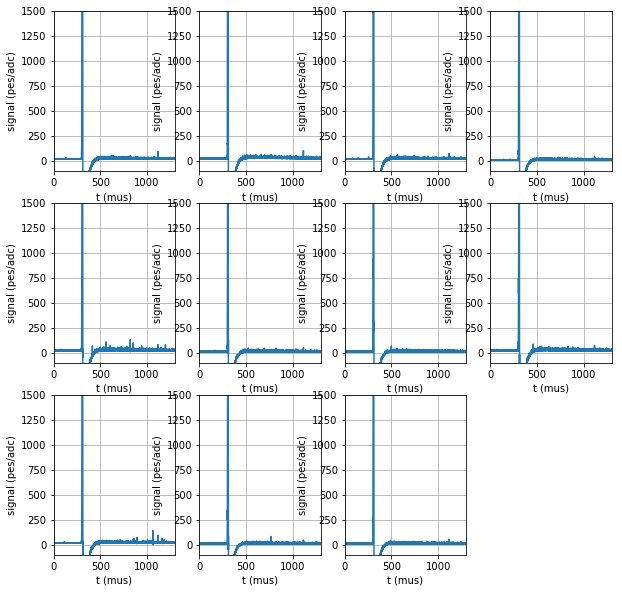

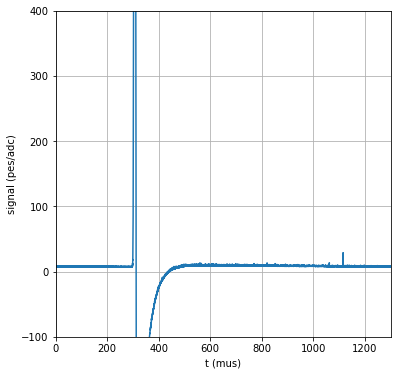

In [65]:
event=18
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 2)
peak number = 0: Peak(samples = 16 width =      0.4 mus , energy =     53.6 pes
        height =      3.8 pes tmin-tmax = minmax(min=493.8, max=494.175) mus  
peak number = 1: Peak(samples = 15 width =      0.3 mus , energy =     54.1 pes
        height =      4.3 pes tmin-tmax = minmax(min=494.475, max=494.825) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 811 width =    809.9 mus , energy = 326745.2 pes
        height =    481.5 pes tmin-tmax = minmax(min=489.58750000000003, max=1299.5) mus  



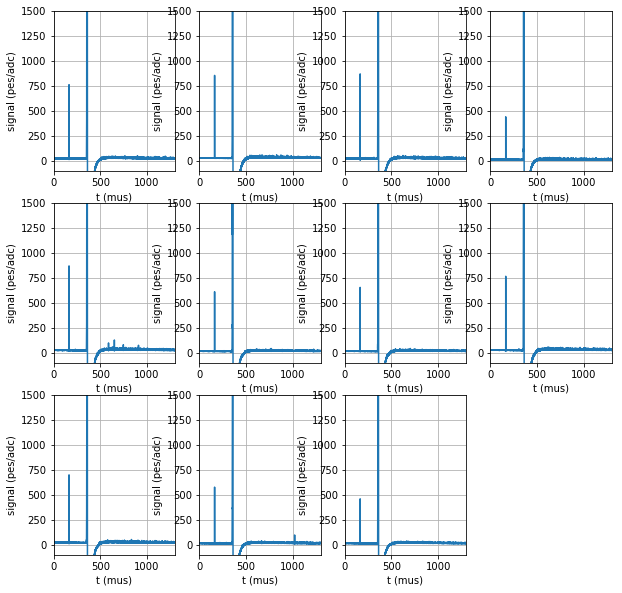

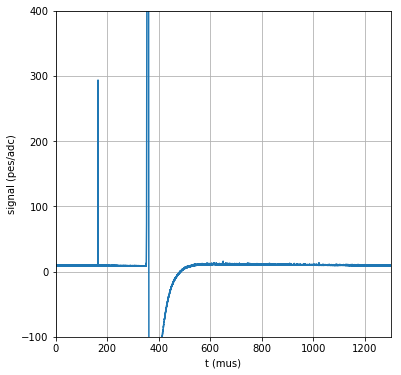

In [66]:
event=19
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 2)
peak number = 0: Peak(samples = 14 width =      0.3 mus , energy =    472.7 pes
        height =     85.8 pes tmin-tmax = minmax(min=161.15, max=161.475) mus  
peak number = 1: Peak(samples = 14 width =      0.3 mus , energy =    383.6 pes
        height =     60.6 pes tmin-tmax = minmax(min=533.6, max=533.925) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 73 width =     71.6 mus , energy = 207140.4 pes
        height =   6844.1 pes tmin-tmax = minmax(min=648.6375, max=720.2125) mus  
peak number = 1: Peak(samples = 10 width =      8.9 mus , energy =   2533.3 pes
        height =    424.1 pes tmin-tmax = minmax(min=1080.5, max=1089.3625) mus  



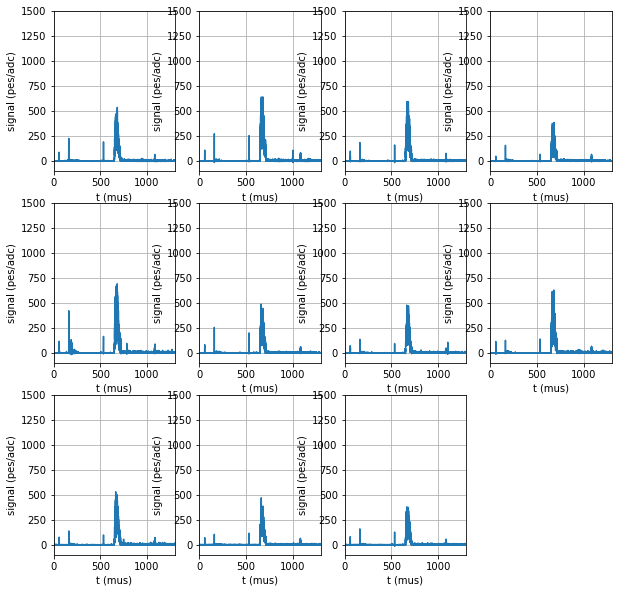

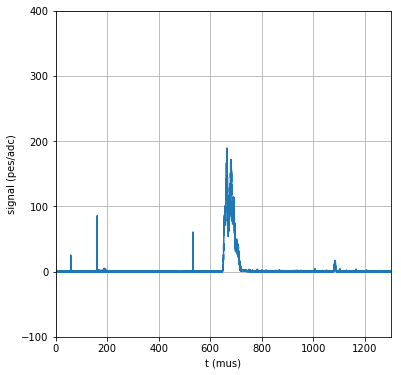

In [67]:
event=20
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      0.2 mus , energy =    273.3 pes
        height =     50.3 pes tmin-tmax = minmax(min=322.875, max=323.125) mus  

S2 (number of peaks = 3)
peak number = 0: Peak(samples = 32 width =     30.4 mus , energy = 180353.7 pes
        height =  14321.5 pes tmin-tmax = minmax(min=648.95, max=679.3875) mus  
peak number = 1: Peak(samples = 4 width =      2.9 mus , energy =    267.9 pes
        height =     80.0 pes tmin-tmax = minmax(min=683.575, max=686.45) mus  
peak number = 2: Peak(samples = 4 width =      2.5 mus , energy =    170.9 pes
        height =     53.7 pes tmin-tmax = minmax(min=699.85, max=702.3625000000001) mus  



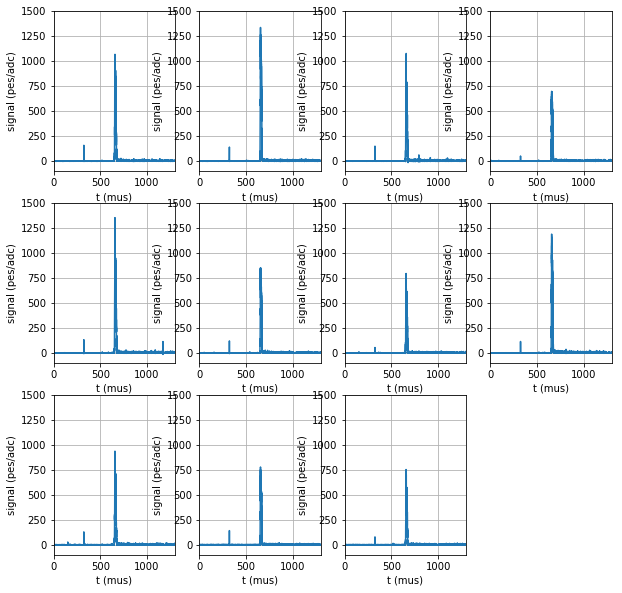

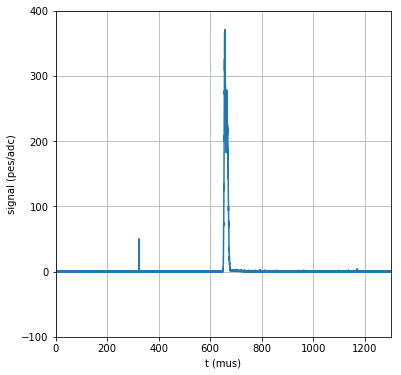

In [68]:
event=21
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 14)
peak number = 0: Peak(samples = 14 width =      0.3 mus , energy =    255.7 pes
        height =     40.7 pes tmin-tmax = minmax(min=128.0, max=128.325) mus  
peak number = 1: Peak(samples = 7 width =      0.1 mus , energy =     -8.1 pes
        height =     -0.8 pes tmin-tmax = minmax(min=495.475, max=495.625) mus  
peak number = 2: Peak(samples = 14 width =      0.3 mus , energy =     16.1 pes
        height =      1.9 pes tmin-tmax = minmax(min=579.9, max=580.225) mus  
peak number = 3: Peak(samples = 11 width =      0.2 mus , energy =     24.6 pes
        height =      3.7 pes tmin-tmax = minmax(min=581.275, max=581.525) mus  
peak number = 4: Peak(samples = 6 width =      0.1 mus , energy =      9.9 pes
        height =      2.1 pes tmin-tmax = minmax(min=583.5, max=583.625) mus  
peak number = 5: Peak(samples = 10 width =      0.2 mus , energy =     18.5 pes
        height =      2.4 pes tmin-tmax = minmax(min=584.75, max=584.975) mus  
peak number = 6: 

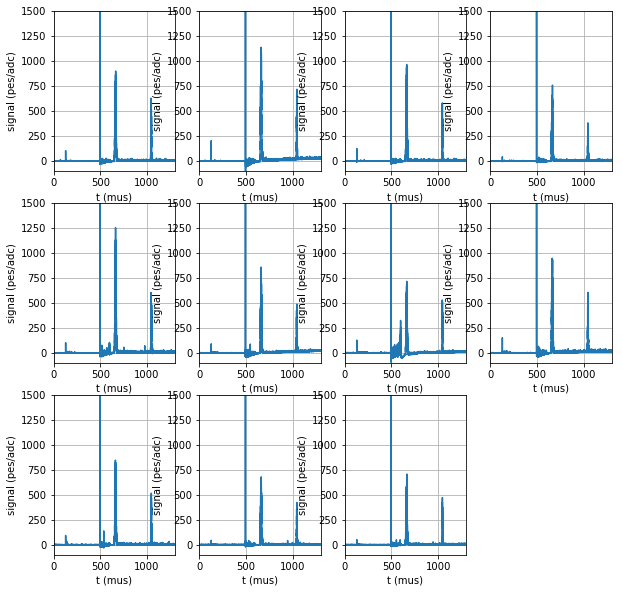

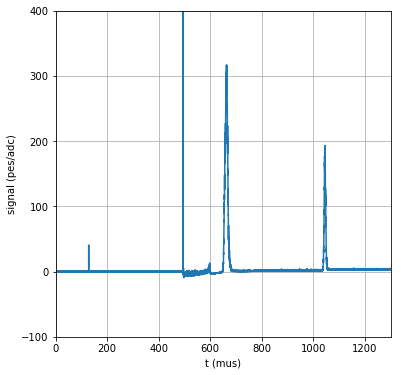

In [69]:
event=22
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =    460.1 pes
        height =     80.3 pes tmin-tmax = minmax(min=221.875, max=222.175) mus  

S2 (number of peaks = 3)
peak number = 0: Peak(samples = 95 width =     93.7 mus , energy = 204921.6 pes
        height =   7342.5 pes tmin-tmax = minmax(min=620.7625, max=714.475) mus  
peak number = 1: Peak(samples = 37 width =     35.5 mus , energy = 115430.3 pes
        height =   9676.7 pes tmin-tmax = minmax(min=740.525, max=776.0500000000001) mus  
peak number = 2: Peak(samples = 13 width =     11.6 mus , energy =   3178.6 pes
        height =    472.7 pes tmin-tmax = minmax(min=1166.7375, max=1178.2875000000001) mus  



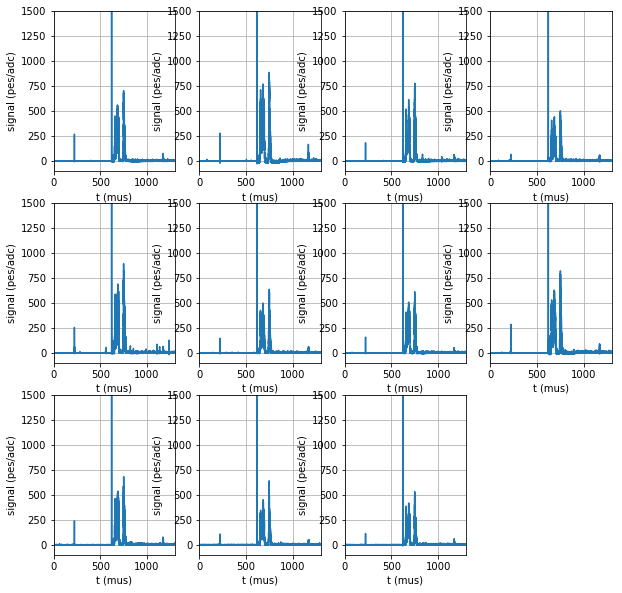

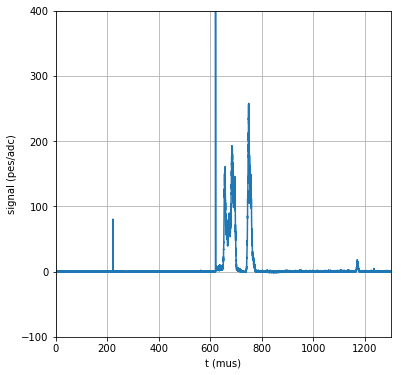

In [70]:
event=23
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 5)
peak number = 0: Peak(samples = 15 width =      0.3 mus , energy =     63.3 pes
        height =      7.3 pes tmin-tmax = minmax(min=460.45, max=460.8) mus  
peak number = 1: Peak(samples = 6 width =      0.1 mus , energy =     19.4 pes
        height =      3.4 pes tmin-tmax = minmax(min=462.325, max=462.45) mus  
peak number = 2: Peak(samples = 12 width =      0.3 mus , energy =     39.1 pes
        height =      3.8 pes tmin-tmax = minmax(min=462.6, max=462.875) mus  
peak number = 3: Peak(samples = 9 width =      0.2 mus , energy =     32.4 pes
        height =      4.0 pes tmin-tmax = minmax(min=464.975, max=465.175) mus  
peak number = 4: Peak(samples = 12 width =      0.3 mus , energy =     42.2 pes
        height =      3.9 pes tmin-tmax = minmax(min=465.325, max=465.6) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 1300 width =   1299.0 mus , energy = 258303.1 pes
        height =  44215.0 pes tmin-tmax = minmax(min=0.5, max=1299.5) mu

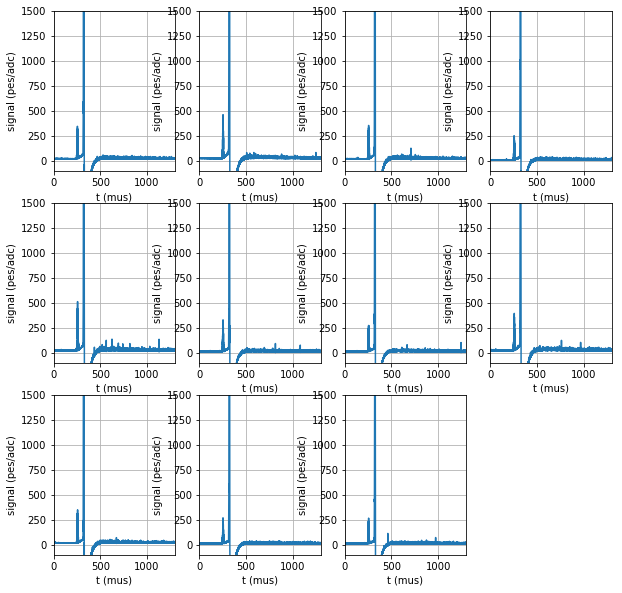

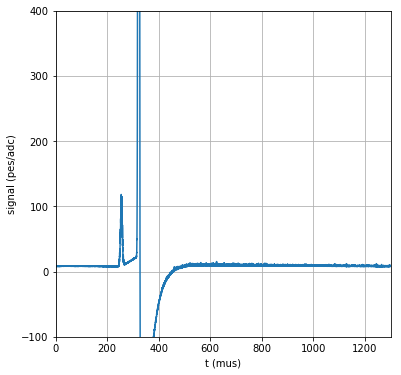

In [71]:
event=24
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 2)
peak number = 0: Peak(samples = 15 width =      0.3 mus , energy =    484.3 pes
        height =     82.6 pes tmin-tmax = minmax(min=126.525, max=126.875) mus  
peak number = 1: Peak(samples = 9 width =      0.2 mus , energy =     65.0 pes
        height =     10.3 pes tmin-tmax = minmax(min=156.525, max=156.725) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 39 width =     37.5 mus , energy = 127826.4 pes
        height =   9856.4 pes tmin-tmax = minmax(min=648.875, max=686.375) mus  
peak number = 1: Peak(samples = 13 width =     11.6 mus , energy =   1071.6 pes
        height =    151.7 pes tmin-tmax = minmax(min=699.6625, max=711.275) mus  



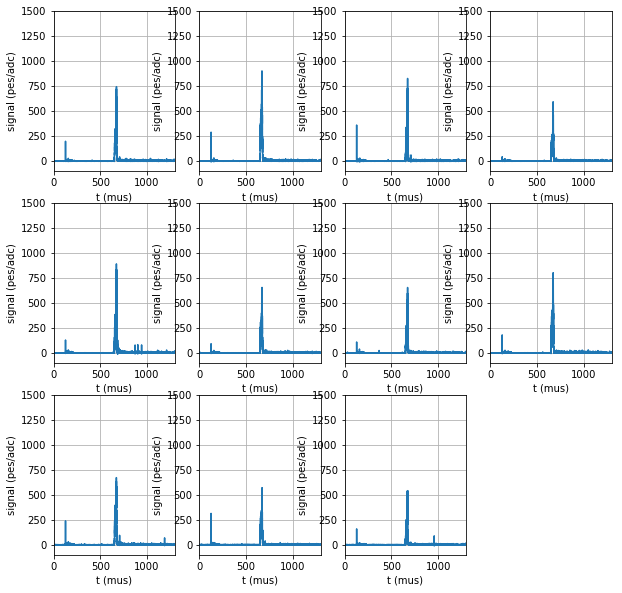

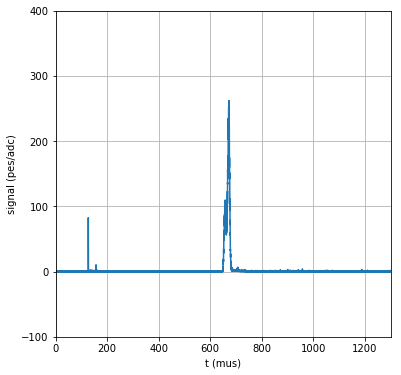

In [72]:
event=25
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 12 width =      0.3 mus , energy =    313.2 pes
        height =     55.6 pes tmin-tmax = minmax(min=164.15, max=164.425) mus  

S2 (number of peaks = 8)
peak number = 0: Peak(samples = 72 width =     70.3 mus , energy = 164921.2 pes
        height =  10964.8 pes tmin-tmax = minmax(min=647.8625000000001, max=718.2) mus  
peak number = 1: Peak(samples = 5 width =      3.5 mus , energy =    181.5 pes
        height =     61.4 pes tmin-tmax = minmax(min=886.8875, max=890.4) mus  
peak number = 2: Peak(samples = 4 width =      2.2 mus , energy =    132.0 pes
        height =     64.8 pes tmin-tmax = minmax(min=900.95, max=903.2) mus  
peak number = 3: Peak(samples = 5 width =      3.6 mus , energy =    239.2 pes
        height =     60.0 pes tmin-tmax = minmax(min=904.825, max=908.4375) mus  
peak number = 4: Peak(samples = 8 width =      6.5 mus , energy =    321.6 pes
        height =     50.0 pes tmin-tmax = minmax(min=919.7875, m

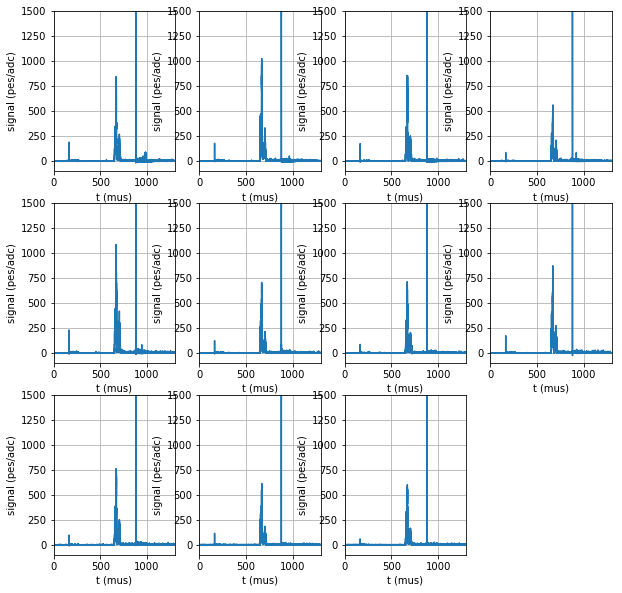

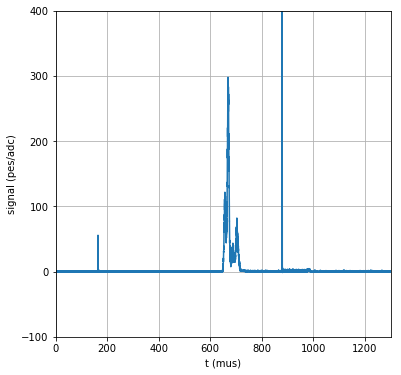

In [73]:
event=26
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 103)
peak number = 0: Peak(samples = 16 width =      0.4 mus , energy =    776.5 pes
        height =    128.6 pes tmin-tmax = minmax(min=140.8, max=141.175) mus  
peak number = 1: Peak(samples = 12 width =      0.3 mus , energy =     50.5 pes
        height =      5.7 pes tmin-tmax = minmax(min=265.075, max=265.35) mus  
peak number = 2: Peak(samples = 9 width =      0.2 mus , energy =     40.3 pes
        height =      5.3 pes tmin-tmax = minmax(min=265.725, max=265.925) mus  
peak number = 3: Peak(samples = 8 width =      0.2 mus , energy =     32.5 pes
        height =      4.7 pes tmin-tmax = minmax(min=266.6, max=266.775) mus  
peak number = 4: Peak(samples = 16 width =      0.4 mus , energy =     50.0 pes
        height =      3.4 pes tmin-tmax = minmax(min=266.9, max=267.275) mus  
peak number = 5: Peak(samples = 10 width =      0.2 mus , energy =     44.2 pes
        height =      6.0 pes tmin-tmax = minmax(min=270.2, max=270.425) mus  
peak number = 6: P

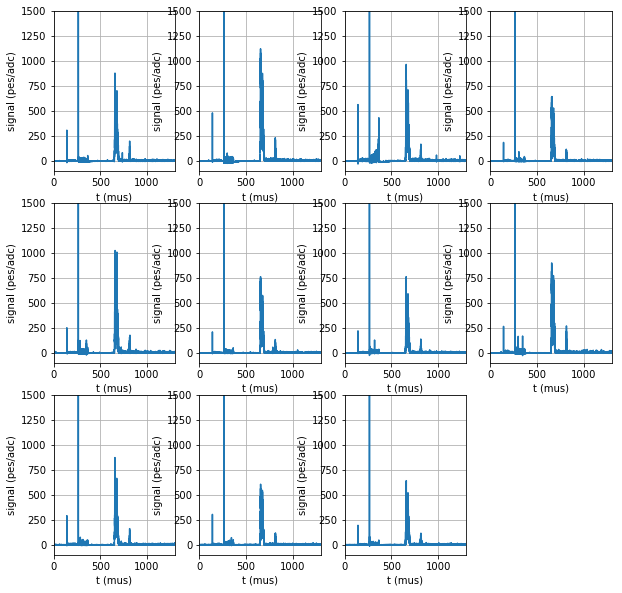

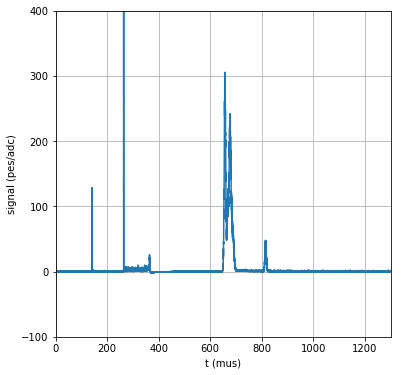

In [74]:
event=27
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 12 width =      0.3 mus , energy =    282.3 pes
        height =     51.2 pes tmin-tmax = minmax(min=554.125, max=554.4) mus  

S2 (number of peaks = 3)
peak number = 0: Peak(samples = 20 width =     18.6 mus , energy =  57840.9 pes
        height =   8148.4 pes tmin-tmax = minmax(min=617.95, max=636.5) mus  
peak number = 1: Peak(samples = 27 width =     25.9 mus , energy = 158804.9 pes
        height =  17379.8 pes tmin-tmax = minmax(min=649.6375, max=675.4875000000001) mus  
peak number = 2: Peak(samples = 3 width =      1.7 mus , energy =    152.3 pes
        height =     62.1 pes tmin-tmax = minmax(min=677.65, max=679.325) mus  



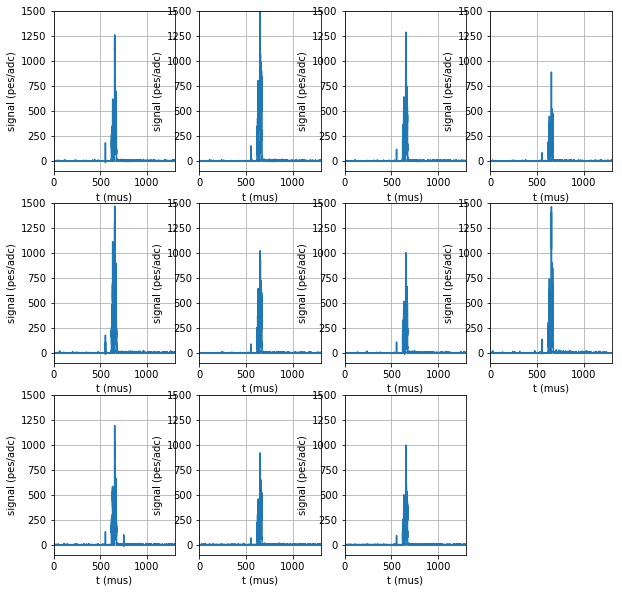

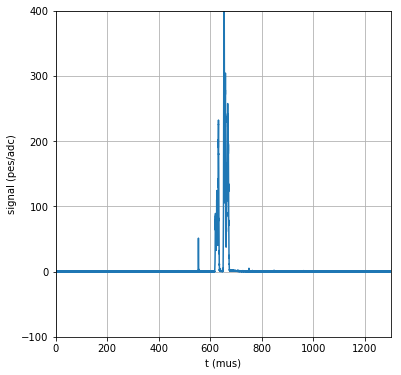

In [75]:
event=28
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 0)

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 797 width =    795.5 mus , energy = 3188715.0 pes
        height =  51393.7 pes tmin-tmax = minmax(min=0.5, max=796.025) mus  
peak number = 1: Peak(samples = 377 width =    375.7 mus , energy = 193806.4 pes
        height =    622.0 pes tmin-tmax = minmax(min=923.775, max=1299.5) mus  



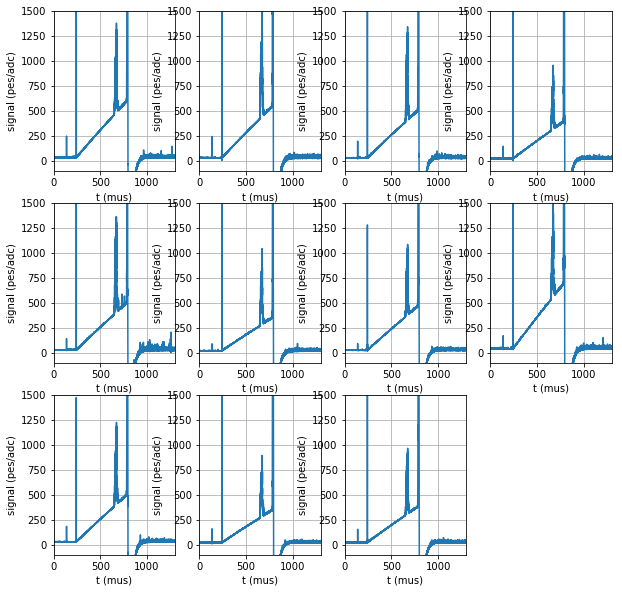

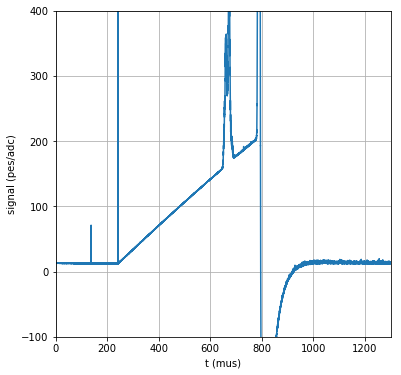

In [76]:
event=29
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 15 width =      0.3 mus , energy =    260.6 pes
        height =     42.3 pes tmin-tmax = minmax(min=198.025, max=198.375) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 41 width =     39.8 mus , energy = 160306.8 pes
        height =  12059.3 pes tmin-tmax = minmax(min=647.6625, max=687.5) mus  
peak number = 1: Peak(samples = 5 width =      3.5 mus , energy =    258.6 pes
        height =     72.1 pes tmin-tmax = minmax(min=692.6750000000001, max=696.1750000000001) mus  



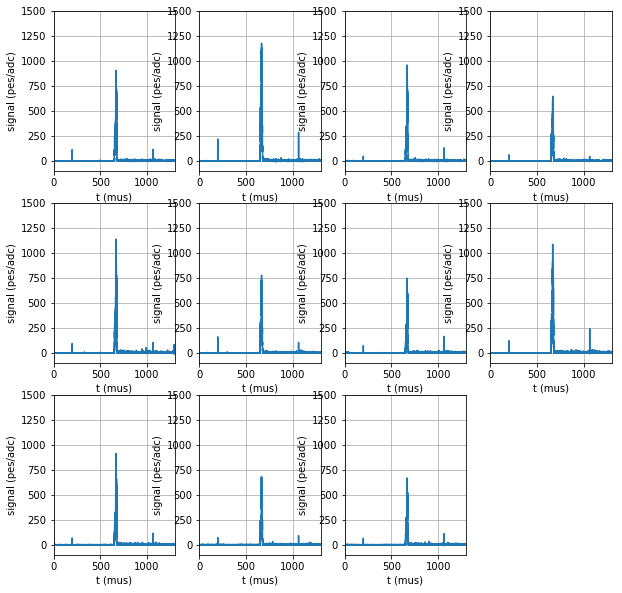

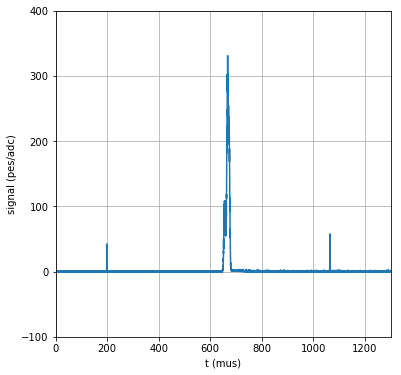

In [77]:
event=30
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

### Event Zoology

#### We can classify the beasts in four species:

1. electrons
2. alpha type 1
3. alpha type 2
4. alpha type 3.

#### Example of electron

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      0.2 mus , energy =    273.3 pes
        height =     50.3 pes tmin-tmax = minmax(min=322.875, max=323.125) mus  

S2 (number of peaks = 3)
peak number = 0: Peak(samples = 32 width =     30.4 mus , energy = 180353.7 pes
        height =  14321.5 pes tmin-tmax = minmax(min=648.95, max=679.3875) mus  
peak number = 1: Peak(samples = 4 width =      2.9 mus , energy =    267.9 pes
        height =     80.0 pes tmin-tmax = minmax(min=683.575, max=686.45) mus  
peak number = 2: Peak(samples = 4 width =      2.5 mus , energy =    170.9 pes
        height =     53.7 pes tmin-tmax = minmax(min=699.85, max=702.3625000000001) mus  



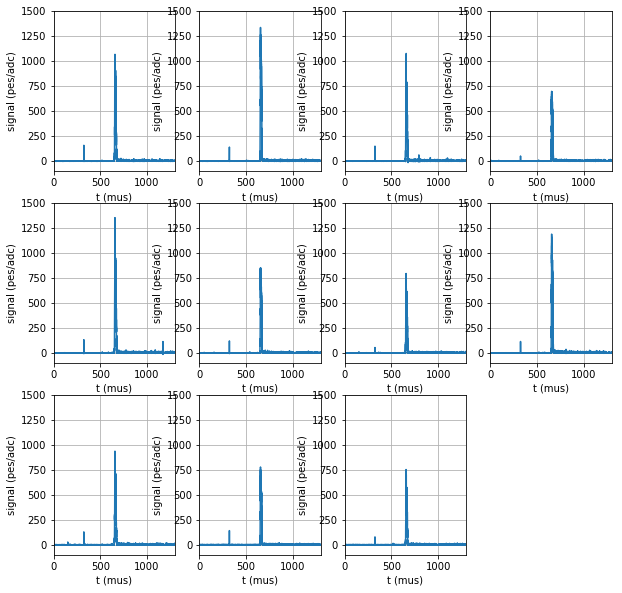

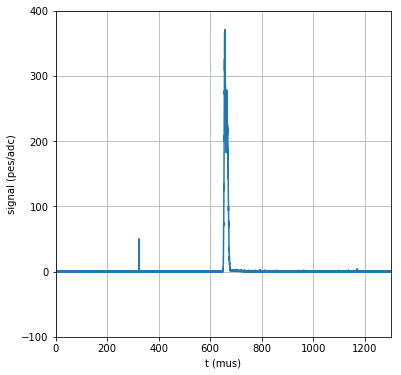

In [78]:
event=21
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

#### example of alpha type 1

S1 (number of peaks = 6)
peak number = 0: Peak(samples = 9 width =      0.2 mus , energy =     29.9 pes
        height =      3.8 pes tmin-tmax = minmax(min=445.65000000000003, max=445.85) mus  
peak number = 1: Peak(samples = 16 width =      0.4 mus , energy =     57.8 pes
        height =      4.3 pes tmin-tmax = minmax(min=447.02500000000003, max=447.40000000000003) mus  
peak number = 2: Peak(samples = 8 width =      0.2 mus , energy =     30.4 pes
        height =      4.4 pes tmin-tmax = minmax(min=447.55, max=447.725) mus  
peak number = 3: Peak(samples = 10 width =      0.2 mus , energy =     31.9 pes
        height =      3.4 pes tmin-tmax = minmax(min=449.175, max=449.40000000000003) mus  
peak number = 4: Peak(samples = 7 width =      0.1 mus , energy =     25.5 pes
        height =      3.9 pes tmin-tmax = minmax(min=449.575, max=449.725) mus  
peak number = 5: Peak(samples = 6 width =      0.1 mus , energy =     22.7 pes
        height =      4.3 pes tmin-tmax = minmax(min

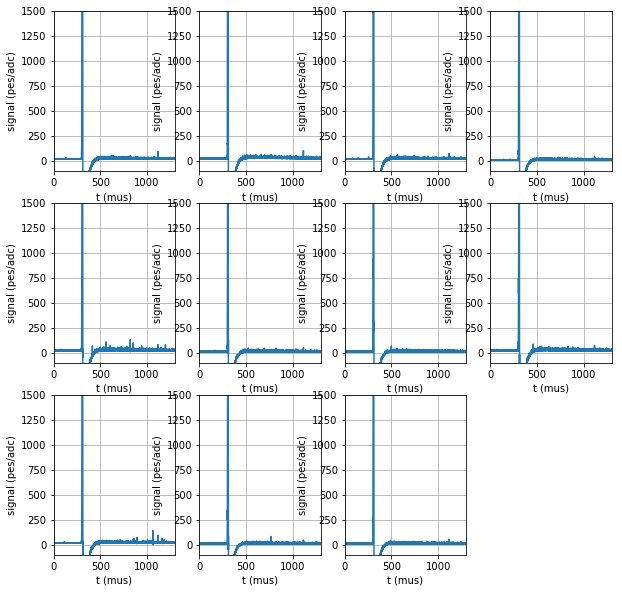

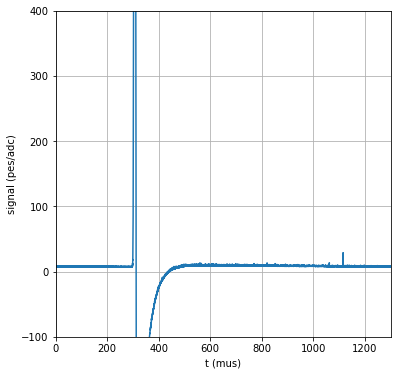

In [79]:
event=18
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

#### example of alpha type 2

S1 (number of peaks = 0)

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 797 width =    795.5 mus , energy = 3188715.0 pes
        height =  51393.7 pes tmin-tmax = minmax(min=0.5, max=796.025) mus  
peak number = 1: Peak(samples = 377 width =    375.7 mus , energy = 193806.4 pes
        height =    622.0 pes tmin-tmax = minmax(min=923.775, max=1299.5) mus  



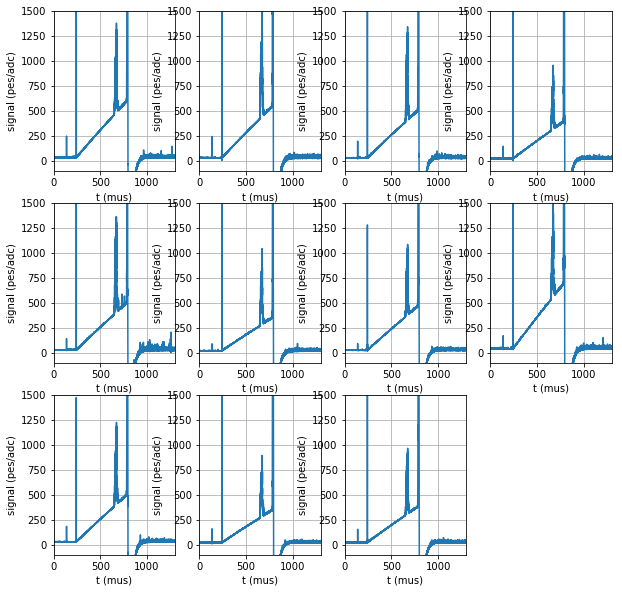

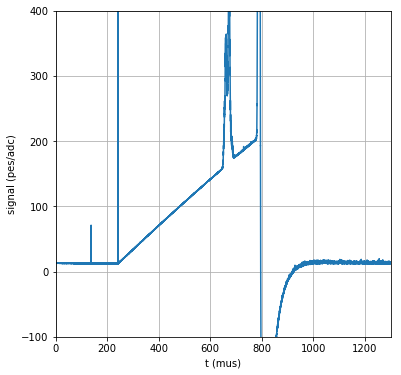

In [80]:
event=29
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

#### example of alpha type 3

S1 (number of peaks = 103)
peak number = 0: Peak(samples = 16 width =      0.4 mus , energy =    776.5 pes
        height =    128.6 pes tmin-tmax = minmax(min=140.8, max=141.175) mus  
peak number = 1: Peak(samples = 12 width =      0.3 mus , energy =     50.5 pes
        height =      5.7 pes tmin-tmax = minmax(min=265.075, max=265.35) mus  
peak number = 2: Peak(samples = 9 width =      0.2 mus , energy =     40.3 pes
        height =      5.3 pes tmin-tmax = minmax(min=265.725, max=265.925) mus  
peak number = 3: Peak(samples = 8 width =      0.2 mus , energy =     32.5 pes
        height =      4.7 pes tmin-tmax = minmax(min=266.6, max=266.775) mus  
peak number = 4: Peak(samples = 16 width =      0.4 mus , energy =     50.0 pes
        height =      3.4 pes tmin-tmax = minmax(min=266.9, max=267.275) mus  
peak number = 5: Peak(samples = 10 width =      0.2 mus , energy =     44.2 pes
        height =      6.0 pes tmin-tmax = minmax(min=270.2, max=270.425) mus  
peak number = 6: P

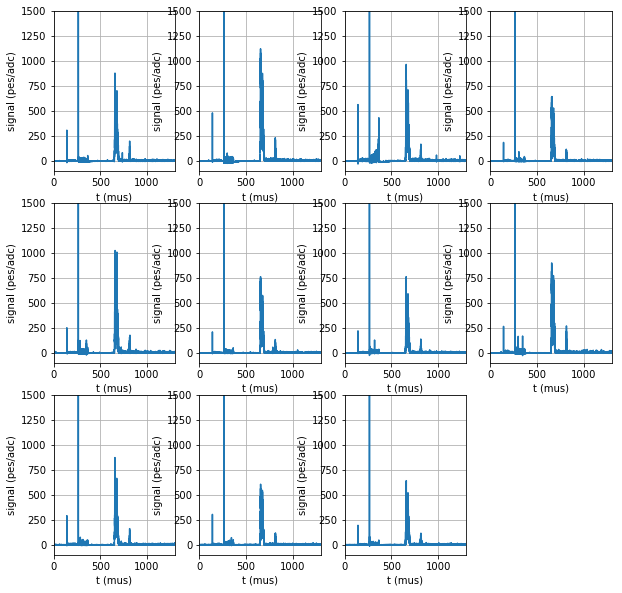

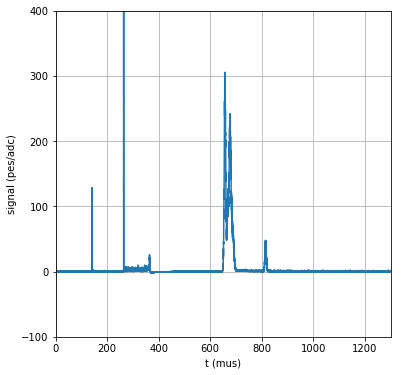

In [81]:
event=27
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      acum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -100,
                             signal_max =  1500)
csum, csum_mau =      cpf.calibrated_pmt_sum(
                               CWF,
                               adc_to_pes,
                               pmt_active = pmt_active,
                               n_MAU = 100,
                               thr_MAU =   3)
plot_signal_vs_time_mus(csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-100, 
                            signal_max=400)
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)

#### Proportions:

1. electrons   : 10
2. alpha type 1: 7
3. alpha type 2: 8
4. alpha type 3: 5

Thus, the ratio of genuine electrons to total is 1/3. Alphas are triggering the system 2/3 of the times. This contributes to explain the low trigger rate of the source. 

It is not clear how the alphas manage to pass through the height cut. One could add an extra cut on width, requesting width < 200 mus. In any case, it seems that the trigger has issues with deconvolution that make it hard to select against alphas.

The good news is that the situation shold improve dramatically as the alpha background is reduced. It is clear that we cannot do much serious work until this happens.